# E2a: Küchentischversuch zum Laval-Rotor

Name:  Martin Cao
Datum:  12.01.2023

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit: 

Wie lassen sich Beschleunigungen mithilfe eines Beschleunigungssensors festhalten? Wie qualitativ sind die Messdaten?

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="images/picture_bass.jpg" width="500">

- Beschreibung des Aufbaus: 
Der Sensor ist direkt an dem Raspberry pi angeschlossen. Dieser ist an eine Basssaite mit Tape befestigt. 
- Vorgangsbeschreibung:
Die Messung wird daraufhin remote von einem anderen Computer gestartet. Beim Bass wird die Saite mit dem befestigten Sensor mehrfach angeschlagen. Am ende der Messung werden die Daten in einer HDF-5-Datei abgespeichert.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [1]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [2]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "measurement_data/data_bass" # replace None by the relative path to the first object's folder
h5_file_name = "data_20240112_134621_MartinCao_bass.h5" # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

In [3]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_bass/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_bass/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_bass/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1ee847c5-6dd5-6ecf-aa58-0341b02a1b83": {
    "type": "probe",
    "name": "compressor",
    "comment": "",
    "path": "measurement_data/data_bass/1ee847c5-6dd5-6ecf-aa58-0341b02a1b83.json"
  }
}
{
  "ID": "1ee847be-fddd-6ee4-89

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [5]:
# Vollständigen Pfad zur HDF5-Datei erstellen
h5_file_path = os.path.join(path_measurement_folder, h5_file_name)
    
    
# UUID des Beschleunigungssensors
acceleration_sensor_uuid = sensor_settings_dict["ID"]

# Öffnen der HDF5-Datei im Lese-Modus
with h5py.File(h5_file_path, 'r') as hdf_file:

        
        # Zugriff auf die Sensorgruppe
        sensor_group = hdf_file[acceleration_sensor_uuid]
        
        # Zugriff auf die Sensorgruppe
        sensor_group = hdf_file[acceleration_sensor_uuid]
        acceleration_x = np.array(sensor_group['acceleration_x'])
        acceleration_y = np.array(sensor_group['acceleration_y'])
        acceleration_z = np.array(sensor_group['acceleration_z'])
        timestamp = np.array(sensor_group['timestamp'])
        
        

print("Beschleunigung X:")
print(acceleration_x)

print("Beschleunigung Y:")
print(acceleration_y)

print("Beschleunigung Z:")
print(acceleration_z)

print("Zeitstempel:")
print(timestamp)

Beschleunigung X:
[0.196133  0.4314926 0.4314926 ... 0.392266  0.392266  0.392266 ]
Beschleunigung Y:
[-7.84532   -9.4536106 -9.4536106 ... -9.1790244 -9.1790244 -9.6889702]
Beschleunigung Z:
[7.2176944 9.7674234 9.7674234 ... 8.1591328 8.1591328 8.3944924]
Zeitstempel:
[2.97808647e-03 7.33017921e-03 1.16198063e-02 ... 1.99930346e+01
 1.99969583e+01 2.00009699e+01]


#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [6]:
vec_am = get_vec_accel(acceleration_x, acceleration_y, acceleration_z)

print(vec_am)

[10.66220552 13.59998159 13.59998159 ... 12.28738416 12.28738416
 12.82565861]


#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


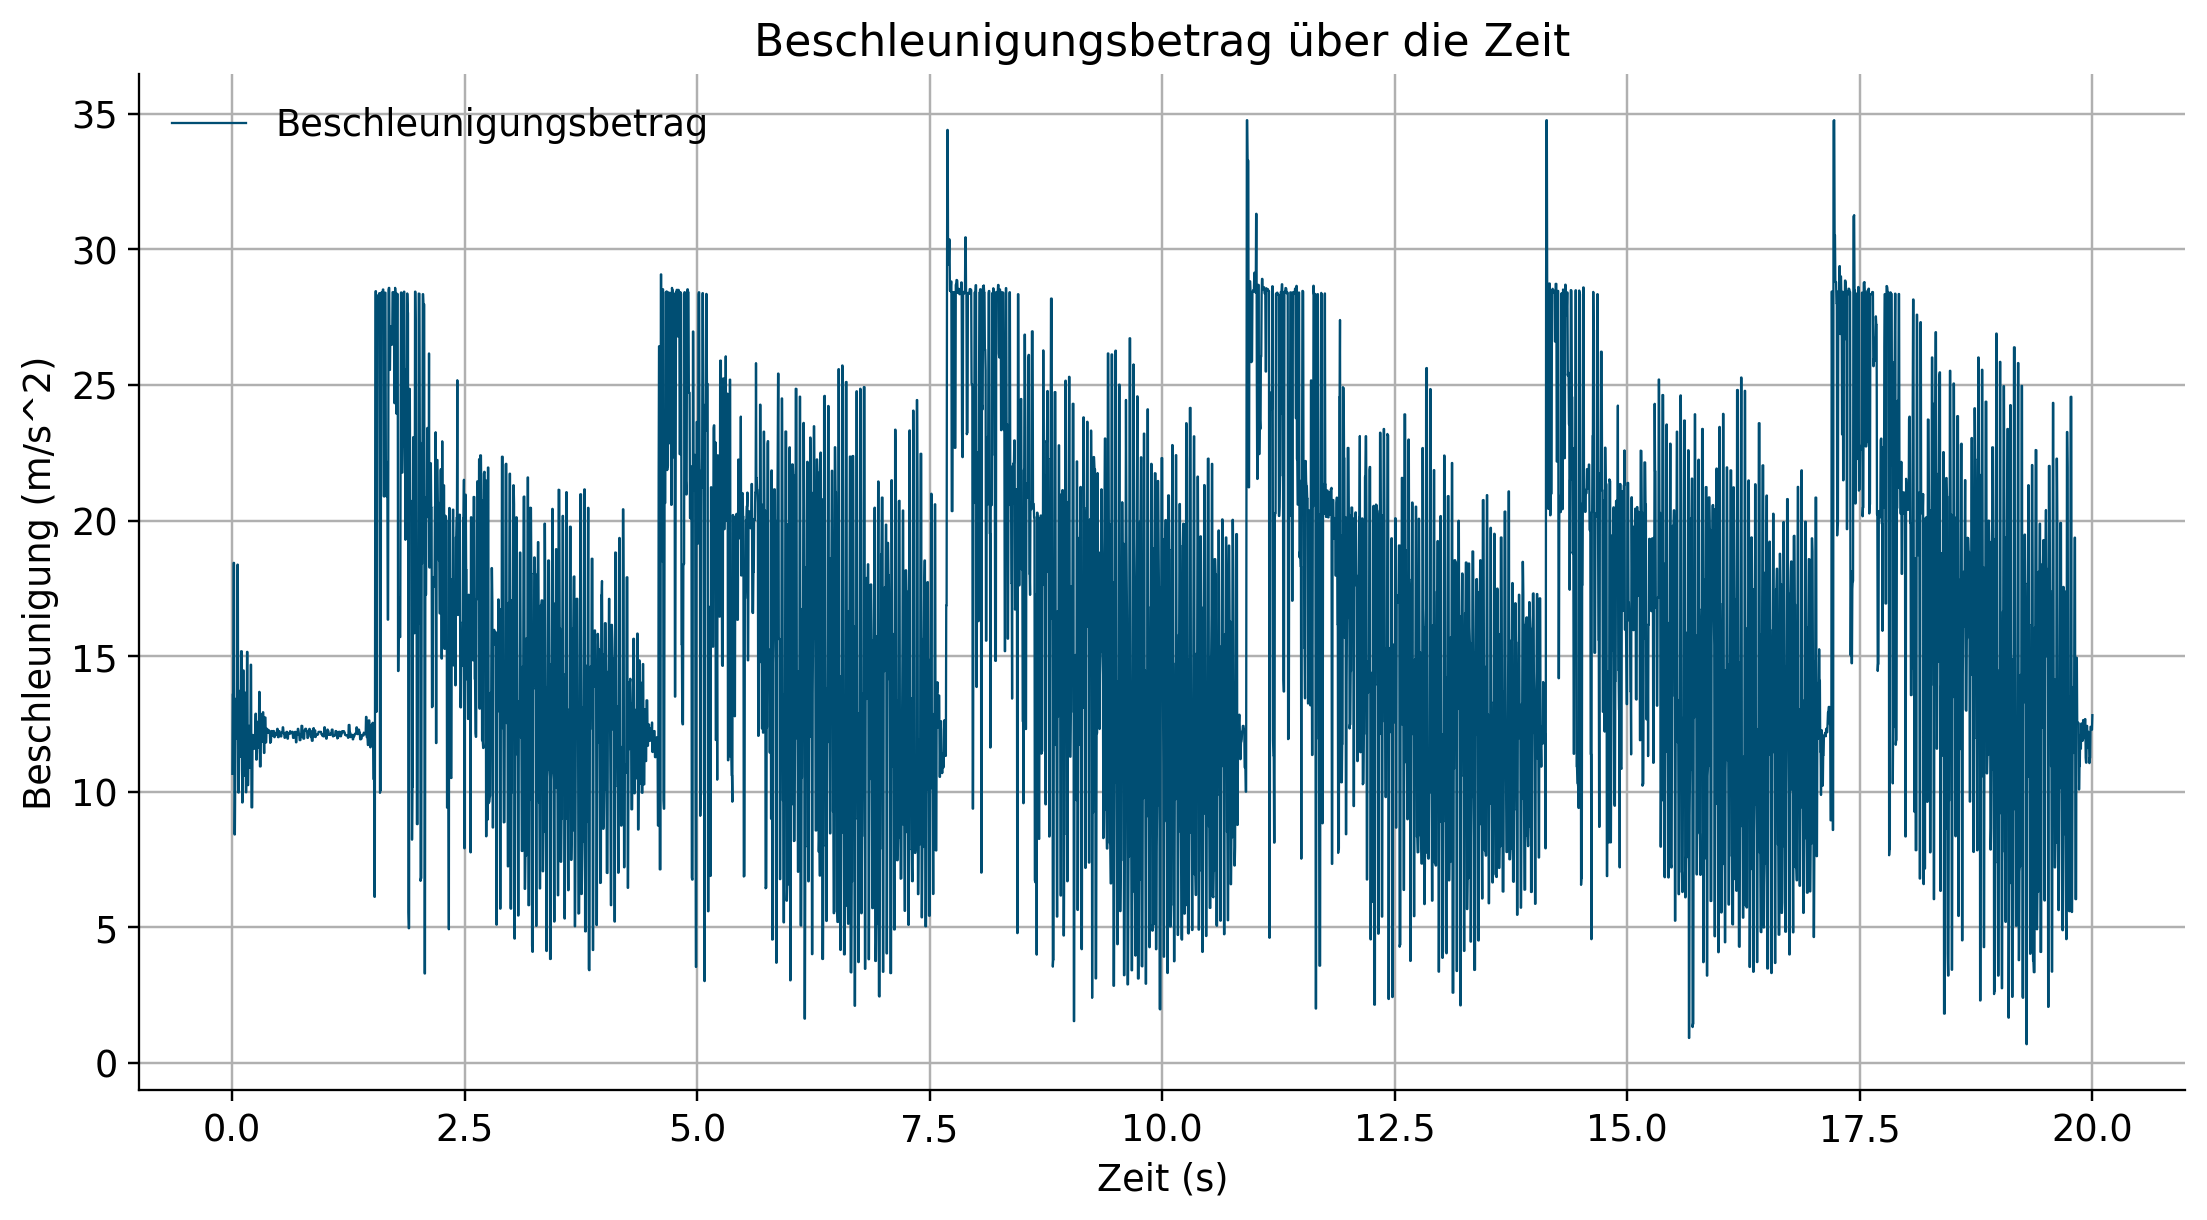

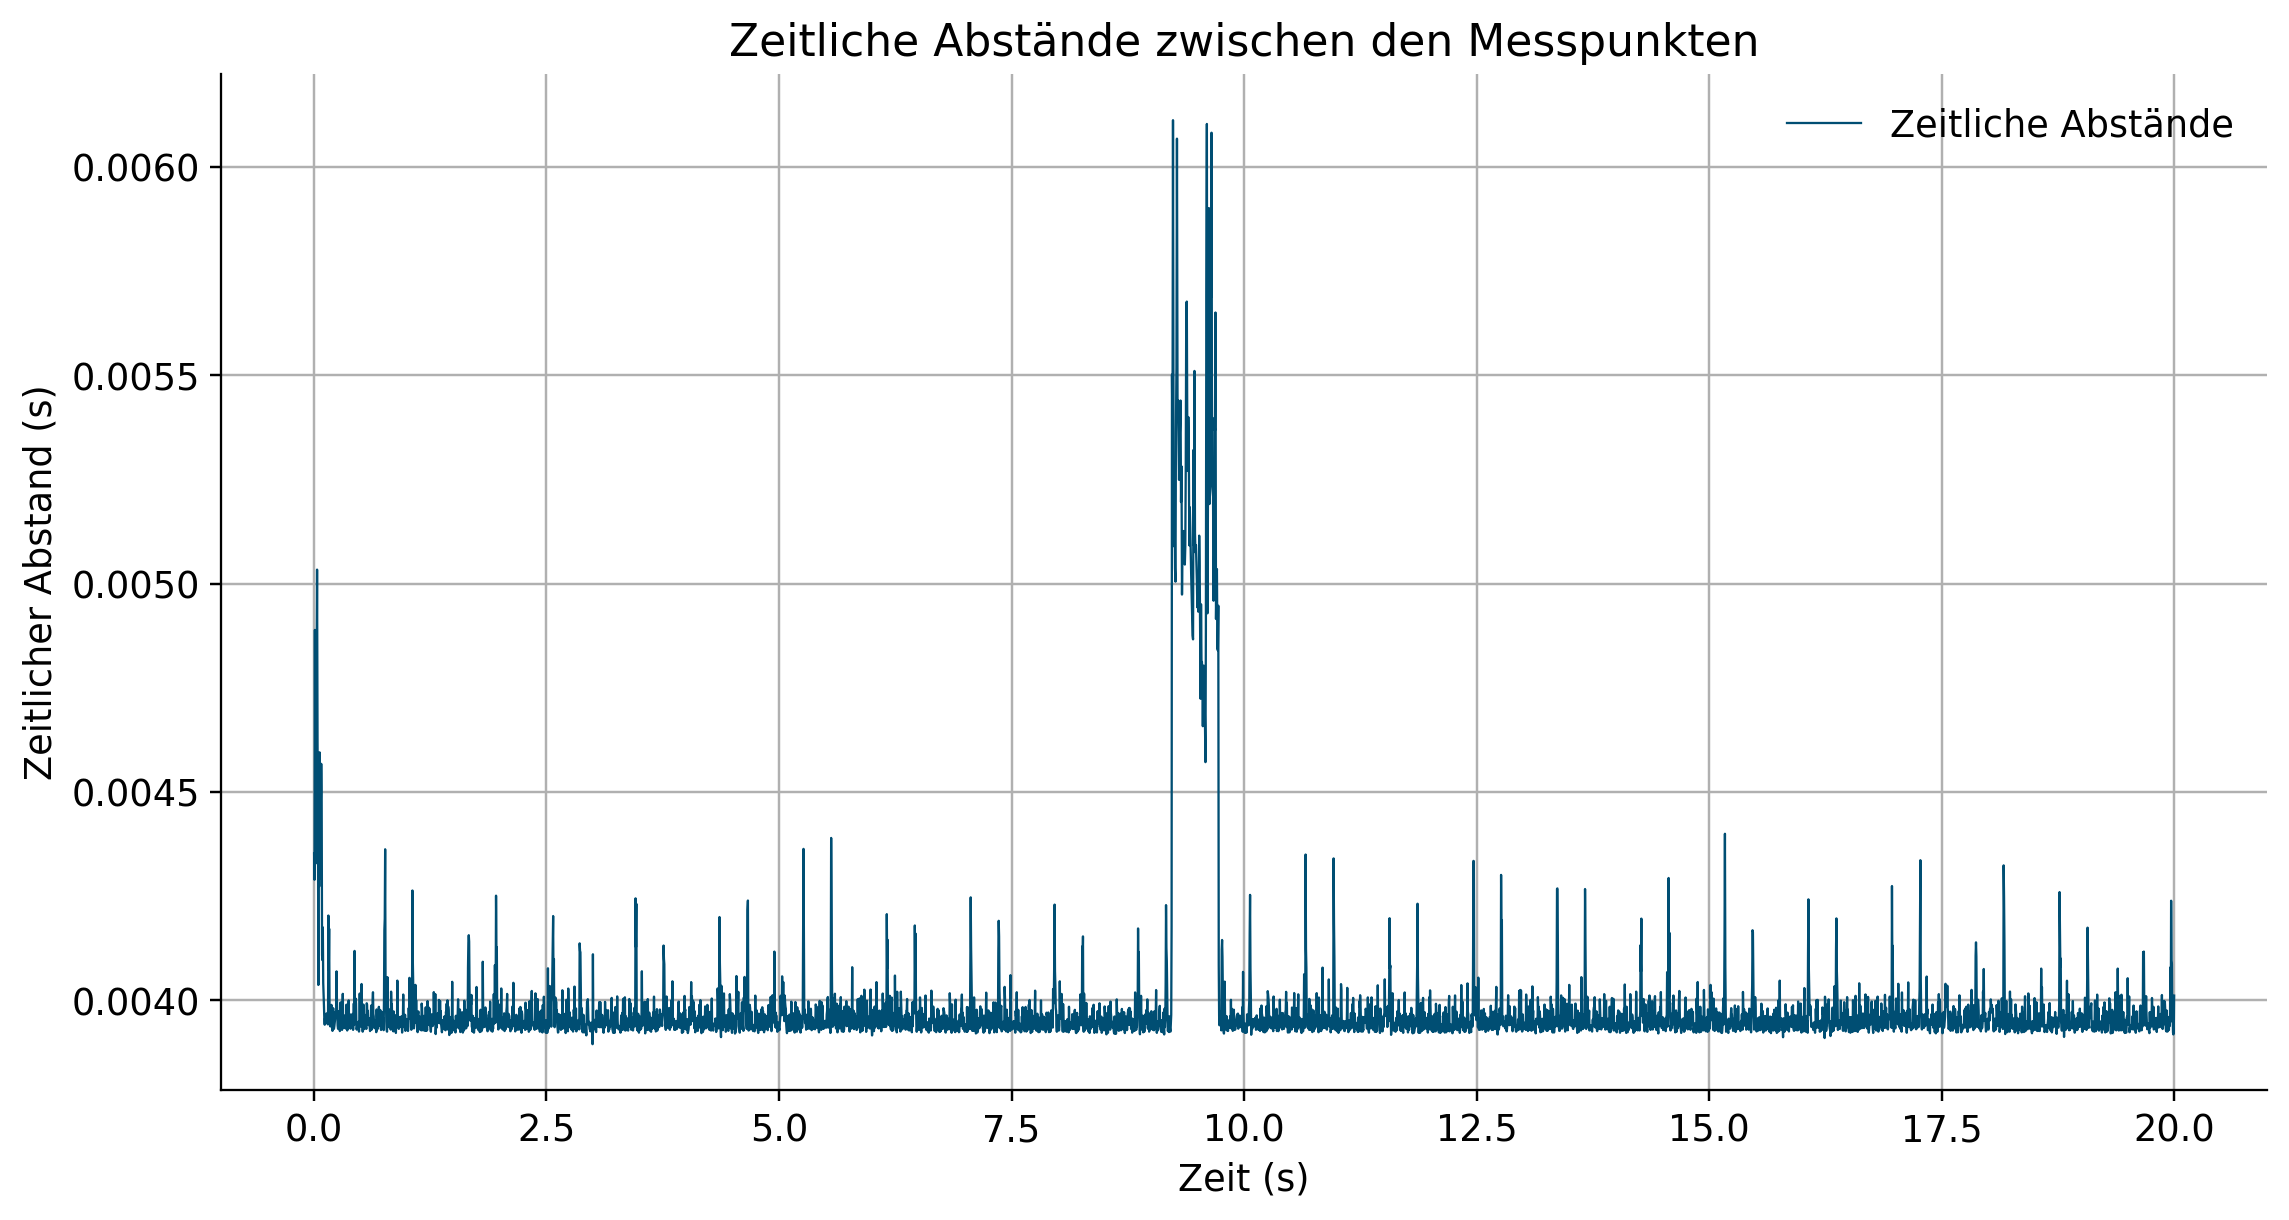

In [7]:
# Berechnen der zeitlichen Abstände zwischen den Messpunkten
time_intervals = np.diff(timestamp)

# Plot der Beträge der Beschleunigung über die Zeit
plt.figure(figsize=(12, 6))
plt.plot(timestamp, vec_am, label='Beschleunigungsbetrag')
plt.title('Beschleunigungsbetrag über die Zeit')
plt.xlabel('Zeit (s)')
plt.ylabel('Beschleunigung (m/s^2)')
plt.legend()
plt.grid(True)
plt.show()

# Plot der zeitlichen Abstände zwischen den Messpunkten
plt.figure(figsize=(12, 6))
plt.plot(timestamp[:-1], time_intervals, label='Zeitliche Abstände')
plt.title('Zeitliche Abstände zwischen den Messpunkten')
plt.xlabel('Zeit (s)')
plt.ylabel('Zeitlicher Abstand (s)')
plt.legend()
plt.grid(True)
plt.show()

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

Interpolierte Daten:
[10.66220552 13.35128238 13.59998159 ... 12.28828231 12.29113677
 12.82565861]


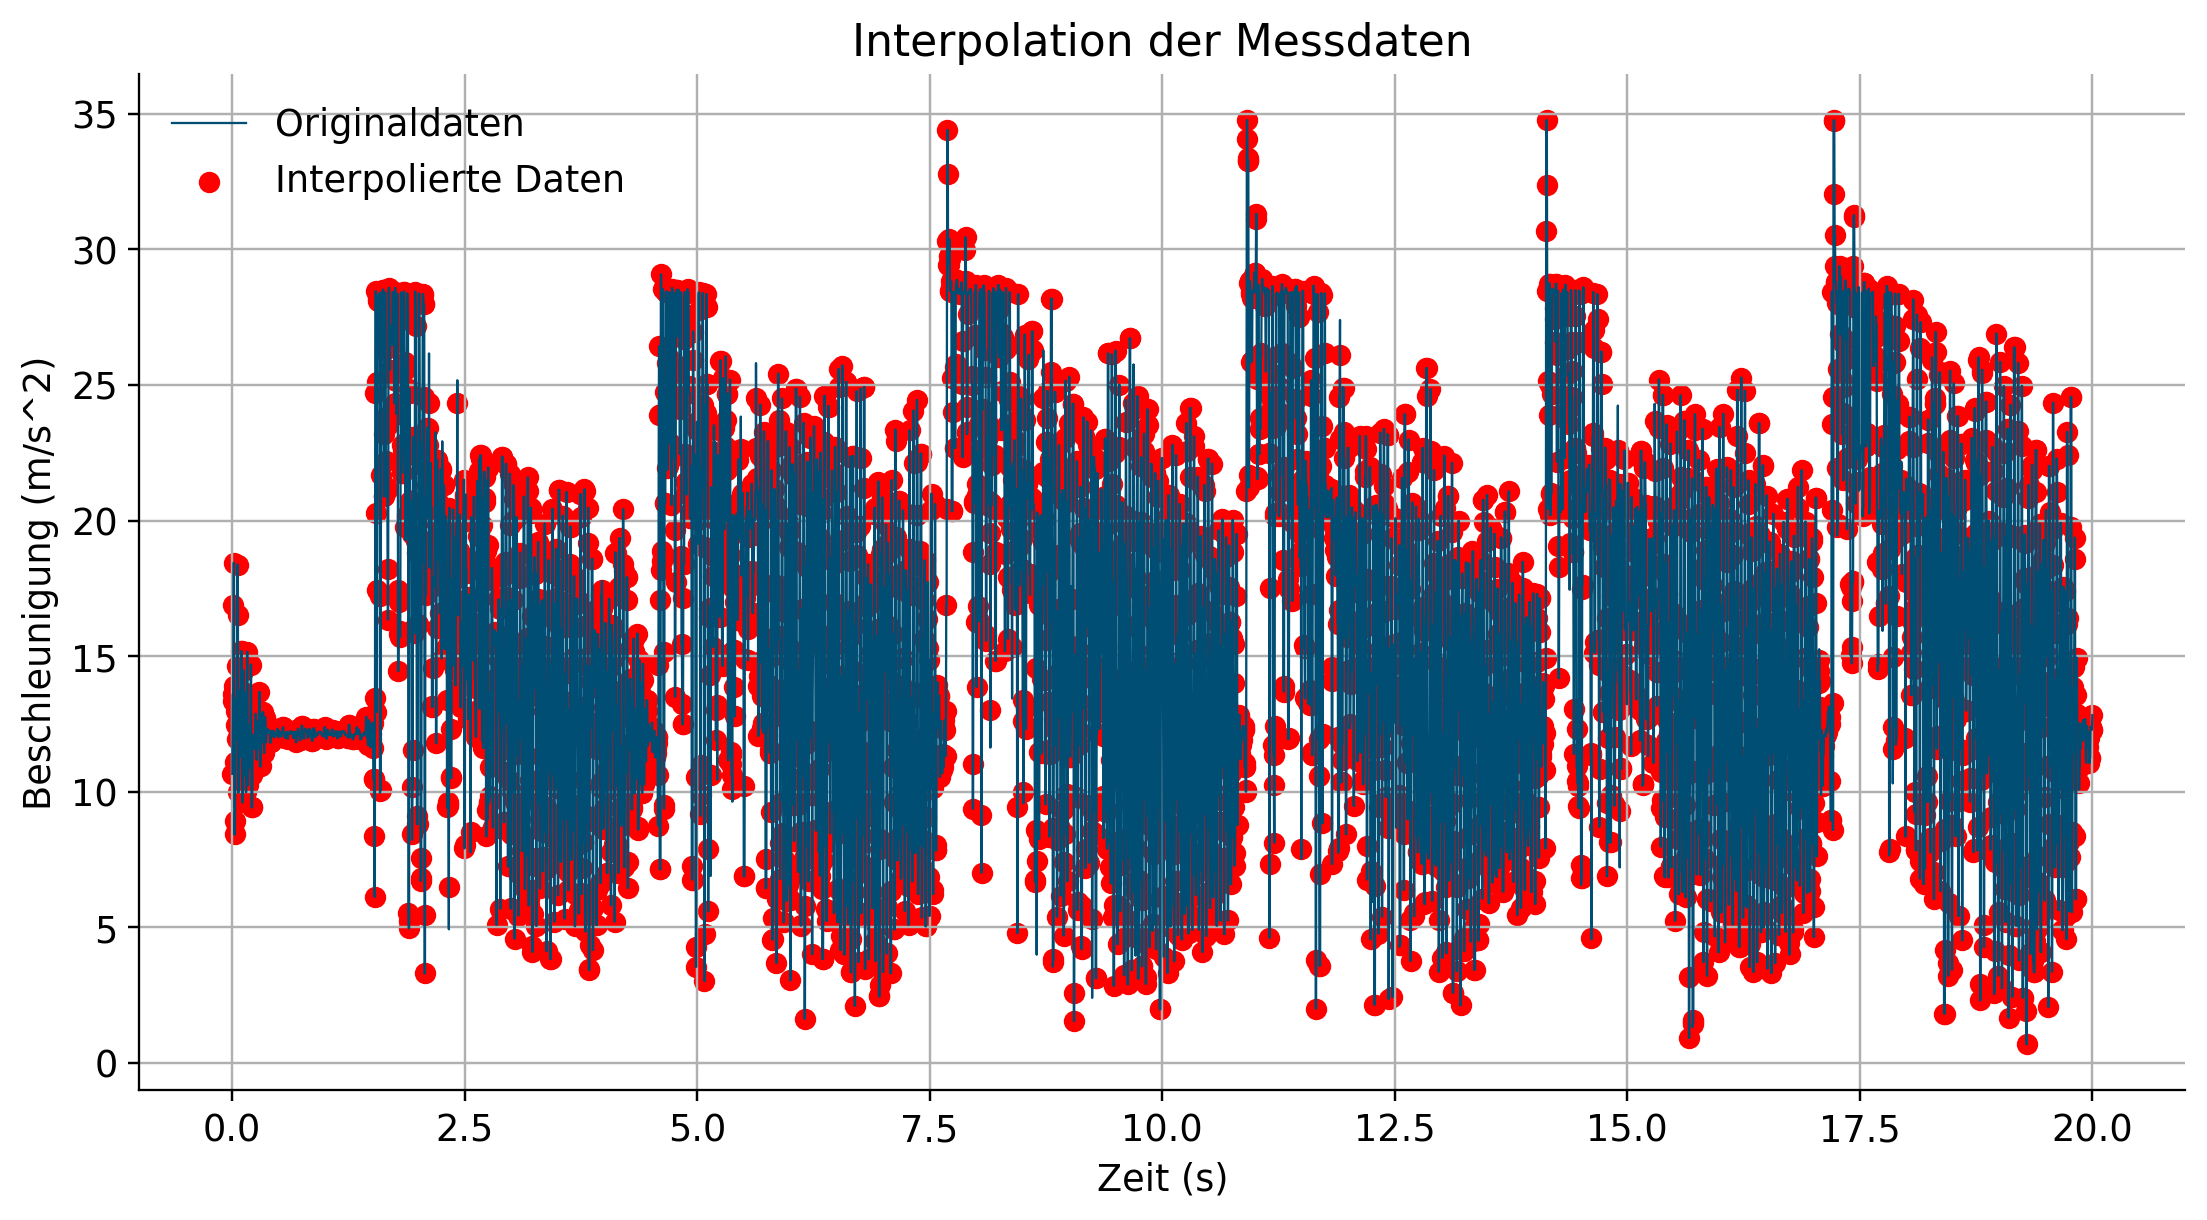

In [8]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.
# Aufruf der interpolation-Funktion
new_time, interpolated_data = interpolation(timestamp, vec_am)

# Ausgabe der interpolierten Daten
print("Interpolierte Daten:")
print(interpolated_data)

# Plot der Originaldaten
plt.figure(figsize=(12, 6))
plt.plot(timestamp, vec_am, label='Originaldaten')
plt.scatter(new_time, interpolated_data, color='red', label='Interpolierte Daten')
plt.title('Interpolation der Messdaten')
plt.xlabel('Zeit (s)')
plt.ylabel('Beschleunigung (m/s^2)')
plt.legend()
plt.grid(True)
plt.show()

#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

In [9]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.

# Aufruf der my_fft-Funktion
amplitude, frequency = my_fft(interpolated_data, new_time)

plt.figure(figsize=(12, 6))
plt.plot(frequency, amplitude)
plt.title('Amplitude des Signals als Funktion der Frequenz (ungefiltert)')
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="images/picture_speaker.jpg" width="500">

- Beschreibung des Aufbaus: Der Sensor ist nun an eine Lautsprechermembran getaped.

- Vorgangsbeschreibung: Die Messung wird durchgeführt, während Musik abgespielt wird. hier Flashing Lights von Kanye West, wegen dem regelmäßigen Beat und elektronischen Instrumenten.

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [10]:
#Pfad zu Messdaten und Zuweisung der HDF5-Datei zu einer Variablen 
path_measurement_folder = "measurement_data/data_speaker" 
h5_file_name = "data_20240112_135633_MartinCao_speaker.h5" 

(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))

{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_speaker/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_speaker/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_speaker/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1ee847c5-6dd5-6ecf-aa58-0341b02a1b83": {
    "type": "probe",
    "name": "compressor",
    "comment": "",
    "path": "measurement_data/data_speaker/1ee847c5-6dd5-6ecf-aa58-0341b02a1b83.json"
  }
}
{
  "ID": "1ee847be-

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [16]:
# Vollständigen Pfad zur HDF5-Datei erstellen
h5_file_path = os.path.join(path_measurement_folder, h5_file_name)
    
    
# UUID des Beschleunigungssensors
acceleration_sensor_uuid = sensor_settings_dict["ID"]

# Öffnen der HDF5-Datei im Lese-Modus
with h5py.File(h5_file_path, 'r') as hdf_file:
        sensor_group = hdf_file[acceleration_sensor_uuid]

        # Auslesen der Daten
        acceleration_x = np.array(sensor_group['acceleration_x'])
        acceleration_y = np.array(sensor_group['acceleration_y'])
        acceleration_z = np.array(sensor_group['acceleration_z'])
        timestamp = np.array(sensor_group['timestamp'])
        
        
# Ausgabe
print("Beschleunigung X:")
print(acceleration_x)

print("Beschleunigung Y:")
print(acceleration_y)

print("Beschleunigung Z:")
print(acceleration_z)

print("Zeitstempel:")
print(timestamp)

Beschleunigung X:
[ 0.784532   0.7453054  0.7453054 ... 20.0447926 20.0447926 20.0447926]
Beschleunigung Y:
[  6.668522    6.668522    6.668522  ...  20.0447926 -20.0840192
 -20.0840192]
Beschleunigung Z:
[ -5.0210048  -4.9425516  -4.9425516 ... -20.0840192 -20.0840192
 -20.0840192]
Zeitstempel:
[3.27825546e-03 7.53092766e-03 1.23131275e-02 ... 1.99927583e+01
 1.99966898e+01 2.00005984e+01]


#### 2. Betrag der Beschleunigung berechnen


In [12]:
 vec_am = get_vec_accel(acceleration_x, acceleration_y, acceleration_z)
    
print(vec_am)

[ 8.38422121  8.33387558  8.33387558 ... 34.74126146 34.76390894
 34.76390894]


#### 3. Darstellung der Messdaten

In [13]:
# Berechnen der zeitlichen Abstände zwischen den Messpunkten
time_intervals = np.diff(timestamp)

# Plot der Beträge der Beschleunigung über die Zeit
plt.figure(figsize=(12, 6))
plt.plot(timestamp, vec_am, label='Beschleunigungsbetrag')
plt.title('Beschleunigungsbetrag über die Zeit')
plt.xlabel('Zeit (s)')
plt.ylabel('Beschleunigung (m/s^2)')
plt.legend()
plt.grid(True)
plt.show()

# zeitliche Abstände zwischen den Messpunkten
plt.figure(figsize=(12, 6))
plt.plot(timestamp[:-1], time_intervals, label='Zeitliche Abstände')
plt.title('Zeitliche Abstände zwischen den Messpunkten')
plt.xlabel('Zeit (s)')
plt.ylabel('Zeitlicher Abstand (s)')
plt.legend()
plt.grid(True)
plt.show()

#### 4. Interpolation der Messwerte



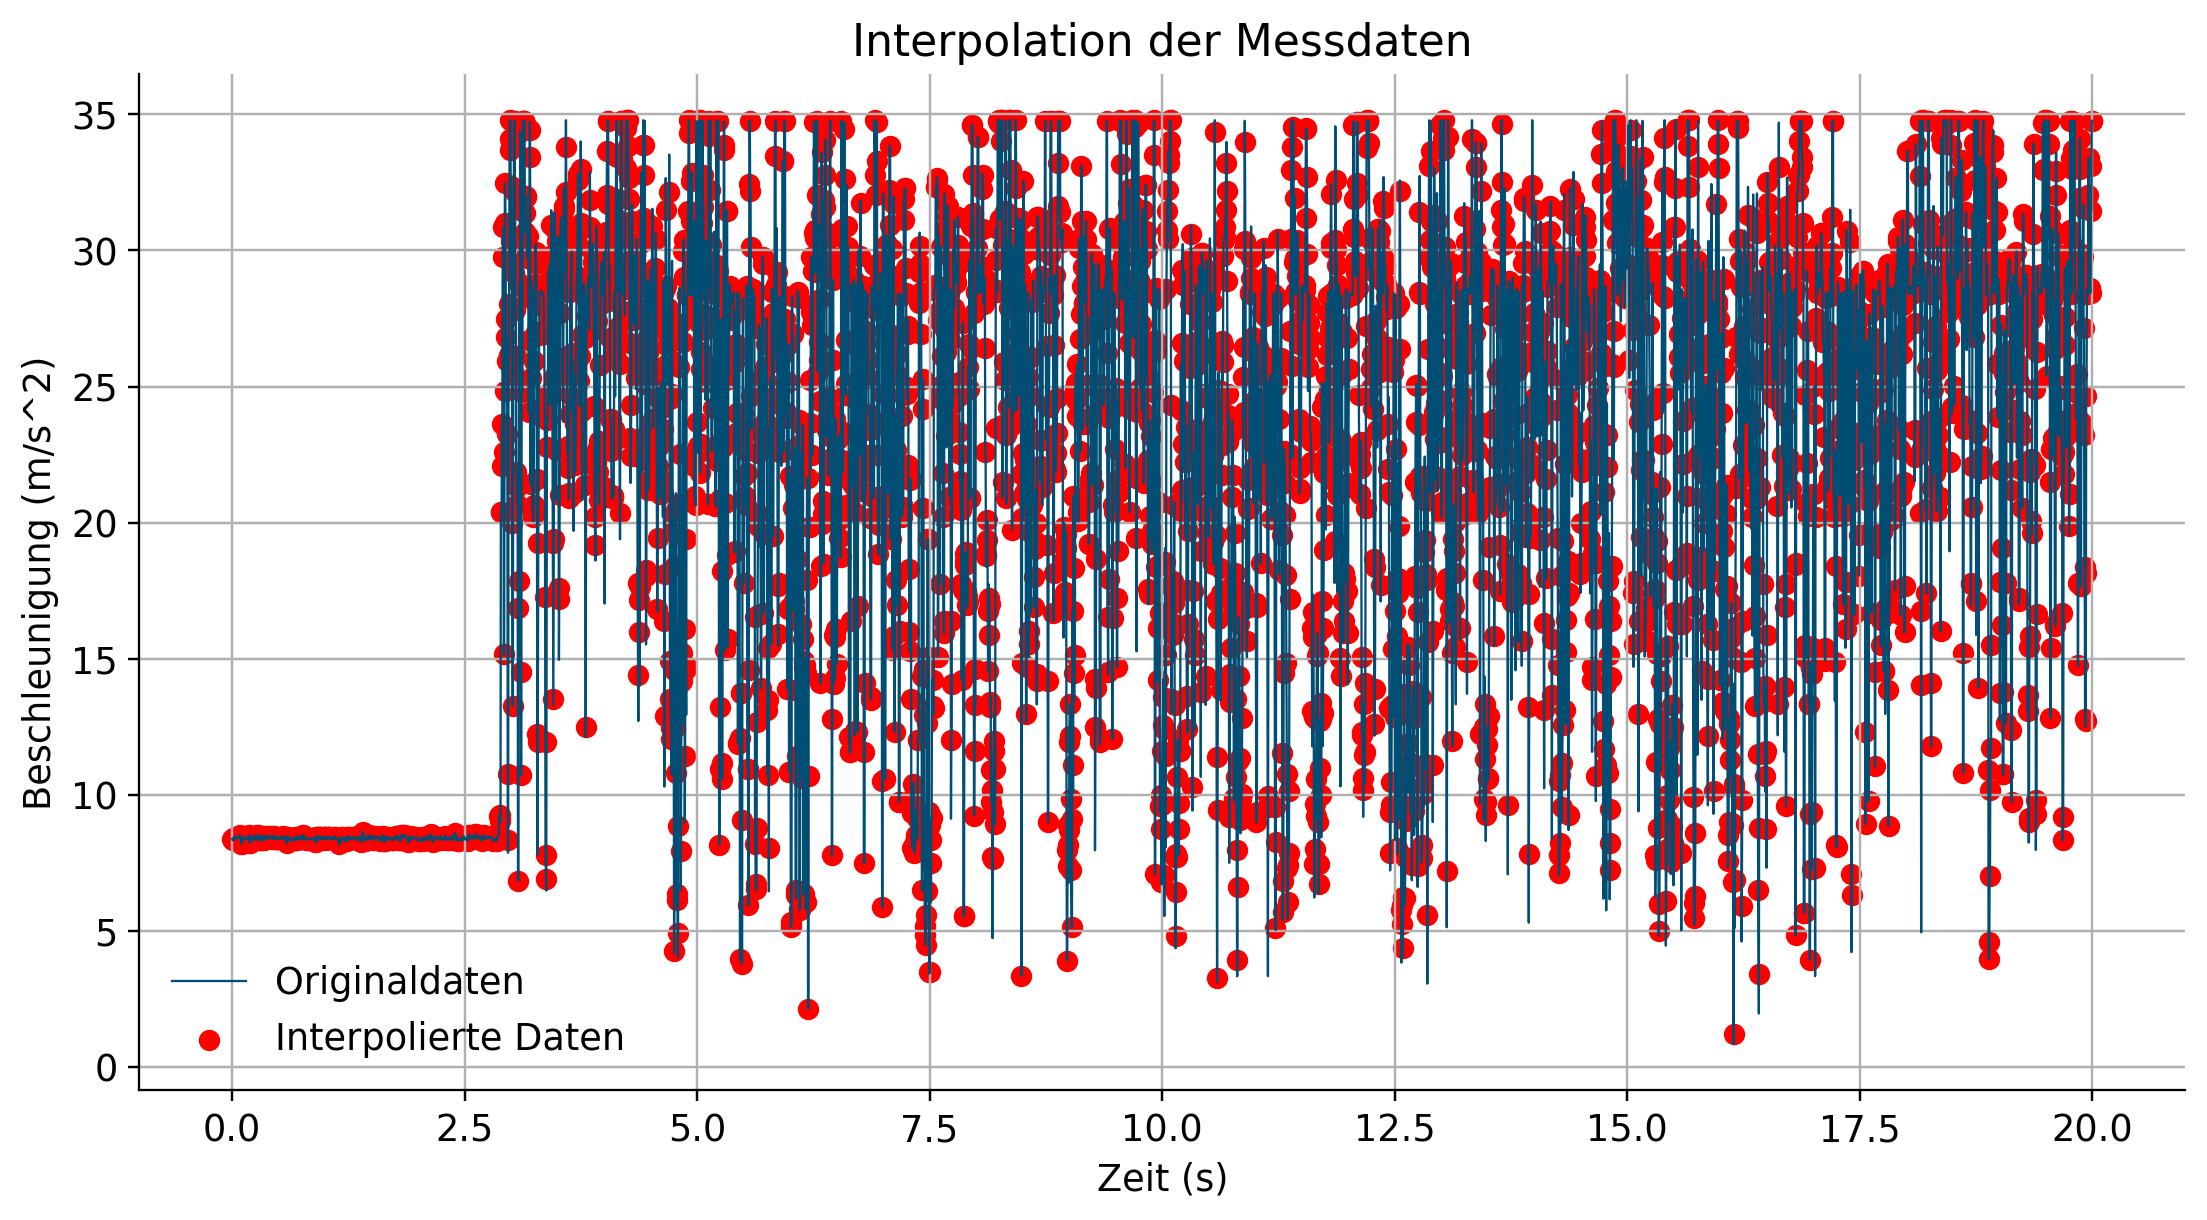

In [14]:
# Aufruf der interpolation-Funktion
new_time, interpolated_data = interpolation(timestamp, vec_am)

# Plot der Originaldaten
plt.figure(figsize=(12, 6))
plt.plot(timestamp, vec_am, label='Originaldaten')
plt.scatter(new_time, interpolated_data, color='red', label='Interpolierte Daten')
plt.title('Interpolation der Messdaten')
plt.xlabel('Zeit (s)')
plt.ylabel('Beschleunigung (m/s^2)')
plt.legend()
plt.grid(True)
plt.show()

#### 5 & 6. FFT durchführen und graphisch darstellen


In [15]:
 # my_fft-Funktion
amplitude, frequenz = my_fft(interpolated_data, new_time)

# Plot der Amplitude als Funktion der Frequenz
plt.figure(figsize=(12, 6))
plt.plot(frequenz, amplitude)
plt.title('Amplitude des Signals als Funktion der Frequenz')
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.


Bei der ersten Messung sieht man sehr gut, dass die Beschleunigung nach jedem Schlag an die Saite abnimmt, bevor die Saite erneut angeschlagen wird. Die zeitlichen Abstände zwischen den Messungen befinden sich hier fast ausschließlich in einem Peak, was der Frequenz des Tons H entsprechen müsste.

Bei der zweiten Messung sieht man einen sehr chaotischen Graphen, was wohl daran liegt, dass Gesang und Instrumente überlagert von der Lautsprechermembran an den Sensor übertragen werden. Bei den zeitlichen Abständen sieht man auch sehr gut, wann die Instrumentation sich ändert, und in welchem Frequenzbereich sich die Drums befinden.

Der Sensor ist allerdings nicht der genauste, weil sich trotz sauberem Signal, immer Irregularitäten zu sehen sind.


## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Trotz dessen würde ich sagen, dass die Daten qualitativ hochwertig sind, weil man das unterschiedliche Verhalten der beiden Versuchsgeräte in den Daten gut erkennen kann. Daher finde ich, dass die Versuche erfolgreich abgelaufen sind. Bei dem Lautsprecher wird ein sehr großer Frequenzbereich abgedeckt, da hätte man vielleicht zur Messung Musik ohne Gesang nehmen müssen, um ein saubereres Ergebnis zu erhalten.